In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### read the data

In [2]:
data_path = "data/bbc-text.csv"
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

labels, sentences = [], []
headlines = True

with open(data_path, "r") as csv_file:
    for line in csv_file:
        if headlines : headlines = False; continue
        
        label, sentence = line.split(',')
        labels.append(label)
        for sw in stopwords:
            sentence = sentence.replace(' '+sw+' ', ' ').replace('  ', ' ')
        sentences.append(sentence)
        
    sentences = np.asarray(sentences)
    labels = np.asarray(labels)
    
print(f"sentences: {len(sentences)}")
print(f"labels: {len(labels)}")
print(f"Sentence0 : {sentences[0][:160]}")
print(f"lable0 : {labels[0]}")

sentences: 2225
labels: 2225
Sentence0 : tv future hands viewers home theatre systems plasma high-definition tvs digital video recorders moving living room way people watch tv will radically different 
lable0 : tech


### preprocess the data

In [47]:
# configuration parameters
vocab_sz = 10000 
max_length = 160
embedding  = 16
oov_tok    = '<oov>'
trunc_type = 'post'
pad_type   = 'post'
num_epochs = 10
categories_length = len(set(labels))

In [22]:
training_portion = 0.8
train_sz = int(training_portion*len(sentences)) 

train_sentences = sentences[:train_sz] 
train_labels = labels[:train_sz]
val_sentences = sentences[train_sz:]
val_labels = labels[train_sz:]

In [31]:
# tokenize and padding the training and validation data.
tokenizer = Tokenizer(num_words=vocab_sz, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=pad_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=pad_type, truncating=trunc_type)

train_padded = np.asarray(train_padded)
val_padded = np.asarray(val_padded)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

449
160
200
160
192
160


In [38]:
# tokenize and padding labels

labels_tokenizer = Tokenizer(num_words=categories_length+1)
labels_tokenizer.fit_on_texts(labels)

train_labels_seq = labels_tokenizer.texts_to_sequences(train_labels)
val_labels_seq = labels_tokenizer.texts_to_sequences(val_labels)

train_labels_seq = np.asarray(train_labels_seq)
val_labels_seq = np.asarray(val_labels_seq)

print(train_labels_seq[0])
print(train_labels_seq[1])
print(train_labels_seq[2])
print(train_labels_seq.shape)

print(val_labels_seq[0])
print(val_labels_seq[1])
print(val_labels_seq[2])
print(val_labels_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


### define -> compile -> fit your model

In [44]:
# define the model
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_sz, embedding, input_length=max_length),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(categories_length+1, activation='softmax')
])

# compile the model with adam optimer and categorical crossentropy and accuracey metric
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# get summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 160, 16)           160000    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 198       
Total params: 160,742
Trainable params: 160,742
Non-trainable params: 0
_________________________________________________________________


In [49]:
# train the model
history = model.fit(train_padded, train_labels_seq, 
          validation_data=(val_padded, val_labels_seq), 
          epochs=num_epochs)

Epoch 1/10
56/56 [==============================] - 0s 5ms/step - loss: 0.0259 - accuracy: 1.0000 - val_loss: 0.1402 - val_accuracy: 0.9573
Epoch 2/10
56/56 [==============================] - 0s 5ms/step - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0.1361 - val_accuracy: 0.9573
Epoch 3/10
56/56 [==============================] - 0s 4ms/step - loss: 0.0181 - accuracy: 1.0000 - val_loss: 0.1323 - val_accuracy: 0.9618
Epoch 4/10
56/56 [==============================] - 0s 5ms/step - loss: 0.0155 - accuracy: 1.0000 - val_loss: 0.1298 - val_accuracy: 0.9618
Epoch 5/10
56/56 [==============================] - 0s 7ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.1273 - val_accuracy: 0.9640
Epoch 6/10
56/56 [==============================] - 0s 9ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.1258 - val_accuracy: 0.9618
Epoch 7/10
56/56 [==============================] - 0s 6ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.1241 - val_accuracy: 0.9640
Epoch 8/10
56/56 [==

### visualize losses and accuracy

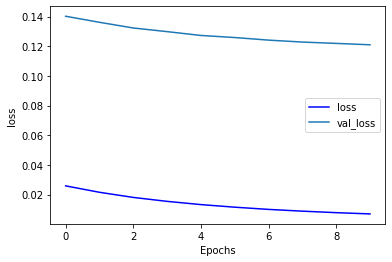

In [61]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string], color='b')
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
    
plot_graphs(history, "loss")

### Decode from words IDs to words text

In [85]:
reverse_word_index = dict([(v, k)for (k, v) in word_index.items()])

def decode_sentence(txt):
    return ' '.join([reverse_index.get(w, '?') for w in txt])

print(decode_sentence(train_padded[0]))

tv future hands viewers home theatre systems plasma high definition tvs digital video recorders moving living room way people watch tv will radically different five years time according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite <oov> us leading trend programmes content will delivered viewers via home networks cable satellite telecoms companies broadband service providers front rooms portable devices one talked about technologies ces digital personal video recorders dvr pvr set top boxes like us s tivo uk s sky system allow people record store play pause forward wind tv programmes want essentially technology allows much personalised tv also built in high definition tv sets big business japan us slower take off europe lack high definition programming not can people forward wind adverts can also forget abiding network channel schedules putting together a la <oov> entertainment us networks cable satellite companies w

#### save word embeddingVectors as tsv files

In [86]:
# get the embedding verctor of words which is the first layer in the model.
embeddings = model.layers[0].get_weights()[0]
print(embeddings.shape)

import io
out_v = io.open("vecs.tsv", "w", encoding='utf-8');
out_m = io.open("meta.tsv", "w", encoding='utf-8')

for i in range(1,vocab_sz):
    wrd = reverse_word_index[i]
    out_m.write(wrd+"\n")
    out_v.write( '\t'.join([ str(v) for v in embeddings[i]]) + '\n')
    
out_m.close()
out_v.close()

(10000, 16)


### Save the model as tfsavedModel

In [87]:
model.save("model/bbc_text_learning_embedding_vectors/bbc_text_classifier.h5")

In [103]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=pad_type, truncating=trunc_type)
print(labels[np.argmax(model.predict(padded)[1])])

print(f"sentence: {sentences[0][:max_length]}")
print(f"actual label: {labels[0]}")

predicted_label = labels[np.argmax(model.predict([train_padded[0]]))]
print(f"predicted label: {predicted_label}")

business
sentence: tv future hands viewers home theatre systems plasma high-definition tvs digital video recorders moving living room way people watch tv will radically different 
actual label: tech
predicted label: tech
